In [1]:
import nltk
import os
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
import pandas as pd
import numpy as np
import torch
from scipy import sparse

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

Importing Amazon's reviews dataset from my google drive:

Note: For more clarification, I have to explaine a little more about the needed features that I have utlized in this chalenge. The first feature is review body which is our independent variable, moreover, the second feature is star_rating that is used as our target(dependent) variable.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/amazon_reviews_us_Watches_v1_00.tsv' , delimiter="\t" , on_bad_lines='skip' , na_values="#")

In [ ]:

data.dropna(axis=0 , inplace=True)

In [3]:
data

NameError: ignored

Note: for the RAM limmitation in the Colab, I utlized just 100000 data samples.

In [ ]:
df = data.iloc[0:100000,[13,7]]

In [ ]:
df["rate"] = df["star_rating"] - 1

In [ ]:
df

,review_body,star_rating,rate
0,Absolutely love this watch! Get compliments al...,5,4
1,I love this watch it keeps time wonderfully.,5,4
2,Scratches,2,1
3,"It works well on me. However, I found cheaper ...",5,4
4,Beautiful watch face. The band looks nice all...,4,3
...,...,...,...
100060,"Too long for my wrist. Otherwise seems good, ...",2,1
100061,Can't say a bad thing about this watch. Price...,5,4
100062,always nice to get what you pay for. Genuine M...,5,4
100063,Very nice watch.,5,4


*** Bert ***

**Tokenization & Encoding**

BERT tokenization is used to convert the raw text into numerical inputs that can be fed into the BERT model. It tokenized the text and performs some preprocessing to prepare the text for the model’s input format. Let’s understand some of the key features of the BERT tokenization model.


-- BERT tokenizer splits the words into subwords or workpieces. For example, the word “geeksforgeeks” can be split into “geeks” “##for”, and”##geeks”. The “##” prefix indicates that the subword is a continuation of the previous one. It reduces the vocabulary size and helps the model to deal with rare or unknown words.

-- BERT tokenizer adds special tokens like [CLS], [SEP], and [MASK] to the sequence. These tokens have special meanings like :

  + [CLS] is used for classifications and to represent the entire input in the case of sentiment analysis,

  + [SEP] is used as a separator i.e. to mark the boundaries between different sentences or segments,

  + [MASK] is used for masking i.e. to hide some tokens from the model during pre-training.

-- BERT tokenizer gives their components as outputs:
 + input_ids: The numerical identifiers of the vocabulary tokens
 + token_type_ids: It identifies which segment or sentence each token belongs to.
 + attention_mask: It flags that inform the model which tokens to pay attention to and which to disregard

**Sequence Length**

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [ ]:
def defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME):
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    return tokenizer

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer=defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in df["review_body"]:
  tokens= tokenizer.encode(txt, max_length= 512, truncation=True)
  token_lens.append(len(tokens))
token_lens
np.max(token_lens)

512

Text(0.5, 0, 'Token count')

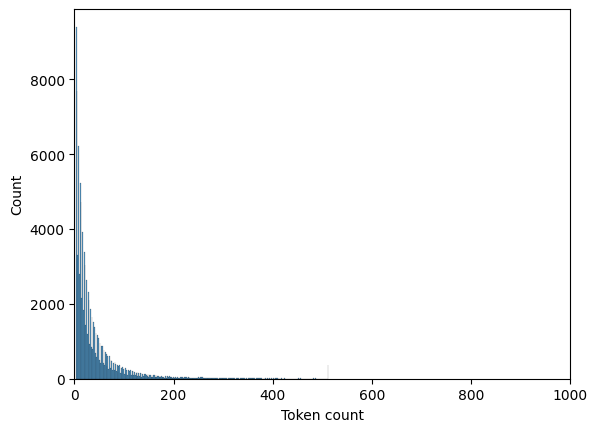

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(token_lens)
plt.xlim([0,1000])
plt.xlabel("Token count")

Note: Based on the depicted plot, our priority is to choose the sentences with 200 tokens. So, the max_len variable equals to 200.

In [ ]:
max_len = 200

Spliting data samples into three subsets (Training - vaidation - Testing [dataset])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train , x_sample , y_train , y_sample = train_test_split(df["review_body"],	df["rate"],
                                                    test_size=0.2)

In [ ]:
x_val, x_test, y_val, y_test = train_test_split(x_sample,
                                                    y_sample,
                                                    test_size=0.5)

In [ ]:
x_train

78151    Very happy with this watch...I was expecting a...
31573                                              Love it
67540                                       Fake not reall
88821    The watch came with dead battery and the built...
13044    Let me just start off saying that I have DaLuc...
                               ...                        
86677                            Great watch , great price
24507                       Love it beautiful color scheme
10619                      For 45$ this watch is schnazzy!
97703                 Quality products thank you very much
40691    large, and awkward to use....cant find the car...
Name: review_body, Length: 80000, dtype: object

In [ ]:
x_test

48277                                           Very nice!
91571                                            excelente
34922    Water got in watch with in a week of using it..:(
6590     This watch is awesome looking just got it toda...
42749    More precise than I thought. No doubt that whe...
                               ...                        
38546                                     Good and pretty.
16423            Awesome! Husband loved his birthday gift!
86707    It looks nice, but feels cheap.  Time will tel...
95115    This watch is a must have if you atre a watch ...
34312    Did not live up to advertising. Clock was unre...
Name: review_body, Length: 10000, dtype: object

In [ ]:
x_val

99644                                               Works!
8127                         Very Nice just hard to put on
62751    The look and the feel of the watch is nice the...
90658    This is the 2nd Daluca strap for my LG Urbane....
64083    Exactly as described. I have a small wrist but...
                               ...                        
85238             Stopped work after being out in the rain
96020     Watch did not work. Had a dead battery probably.
24417                                           nice watch
39369    This watch is exactly what I was looking for -...
28627                                          Great watch
Name: review_body, Length: 10000, dtype: object

 **Apply the BERT tokenization in training, testing and validation sets**

 In this step, we tokenize our training sets. In fact, tokenizer dedicates a number or unicode to each token that this matter has been shown in the down cells.

In [ ]:
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(x_train.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [ ]:
k = 0
print('Training Comments -->>', x_train[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',y_train[k])

Training Comments -->> Absolutely love this watch! Get compliments almost every time I wear it. Dainty.

Input Ids -->>
 tf.Tensor(
[  101  2200  3407  2007  2023  3422  1012  1012  1012  1045  2001  8074
  1037  3422  2559  2066  1037  9121  1012  1012  1012  2021  2053 23161
  1012  1012  1012  2049  3376  1998  1996  7708  3494  2024  8989  3085
  1012  2026  2684  7459  2009  1012   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     

**Build the classification model**

In [ ]:
from transformers import TFBertForSequenceClassification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compile the model with an appropriate optimizer, loss function, and metrics
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# Train the model
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    y_train,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=3)

Epoch 1/3
2500/2500 [==============================] - 3567s 1s/step - loss: 0.7148 - accuracy: 0.7252 - val_loss: 0.6468 - val_accuracy: 0.7493
Epoch 2/3
2500/2500 [==============================] - 3589s 1s/step - loss: 0.6052 - accuracy: 0.7631 - val_loss: 0.6287 - val_accuracy: 0.7546
Epoch 3/3
2500/2500 [==============================] - 3590s 1s/step - loss: 0.5336 - accuracy: 0.7920 - val_loss: 0.6584 - val_accuracy: 0.7561


In [ ]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

313/313 [==============================] - 145s 464ms/step - loss: 0.6979 - accuracy: 0.7436
Test loss: 0.697908878326416, Test accuracy: 0.7436000108718872
